# Options 4: Hedging Options

This notebook illustrates how to hedge an option by holding a position in the underlying asset (delta hedging).

## Load Packages and Extra Functions

In [1]:
using Printf, Distributions

include("jlFiles/printmat.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# A First-Order Approximation of the Option Price Change

"Delta hedging" is based on the idea that we can approximate the change in the option price by 

$C_{t+h}-C_{t}\approx \Delta_t \left(  S_{t+h}-S_{t}\right)$,

where $\Delta_t$ is the derivative of the call option price wrt. the underlying asset price. (It does *not* indicate a first difference.)

In the Black-Scholes model, the delta of a call option is

$\Delta=\frac{\partial C}{\partial S}=e^{-\delta m}\Phi\left(  d_{1}\right),$ 

where $d_1$ is the usual term in Black-Scholes and $\delta$ is the continuous dividend rate (possibly 0).

Similarly, the delta of a put option is 

$\frac{\partial P}{\partial S}=e^{-\delta m}[\Phi\left(  d_{1}\right)-1]$.

The file included in the next cell contains the functions `Φ()` and `OptionBlackSPs()` from the chapter on the Black-Scholes model. 

The subsequent cell defines a function for the $\Delta$ of the Black-Scholes model.

In [3]:
include("jlFiles/OptionsCalculations.jl");

In [4]:
"""
Calculate the Black-Scholes delta
"""
function OptionDelta(S,K,m,y,σ,δ=0;isPut=false)
    d1 = ( log(S/K) + (y-δ+0.5*σ^2)*m ) / (σ*sqrt(m))
    d2 = d1 - σ*sqrt(m)
    Δ = isPut ? exp(-δ*m)*(Φ(d1)-1) : exp(-δ*m)*Φ(d1)   #put or call
    return Δ
end

OptionDelta

In [5]:
(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)

Δ_c = OptionDelta(S,K,m,y,σ)               #call
Δ_p = OptionDelta(S,K,m,y,σ,0;isPut=true)  #put

printblue("Δ:\n")
printmat([Δ_c Δ_p (Δ_c-Δ_p)];colNames=["call","put","difference"],width=12,colUnderlineQ=true)

Δ:

        call         put  difference
        ¯¯¯¯         ¯¯¯  ¯¯¯¯¯¯¯¯¯¯
       0.598      -0.402       1.000



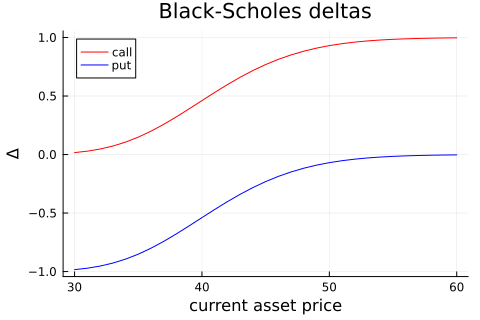

In [6]:
S_range = 30:60          #different spot prices
Δ_c_S   = OptionDelta.(S_range,K,m,y,σ)
Δ_p_S   = OptionDelta.(S_range,K,m,y,σ;isPut=true)

p1 = plot( S_range,[Δ_c_S Δ_p_S],
           linecolor = [:red :blue],
           label = ["call" "put"],
           title = "Black-Scholes deltas",
           xlabel = "current asset price",
           ylabel = "Δ" )
display(p1)

# Hedging an Option

The example below shows how delta hedging works for a European call option when the price of the underlying asset changes (from 42 on day 0 to 43 on day 1). For simplicity, we assume that the Black-Scholes model is a good description of how the option price is set.

In [7]:
(S₀,S₁,K,m,y,σ) = (42,43,42,0.5,0.05,0.2)   #prices before, after, parameters

C₀ = OptionBlackSPs(S₀,K,m,y,σ)   #option price at S₀
Δ₀ = OptionDelta(S₀,K,m,y,σ)      #Delta at S₀
M₀ = C₀ - Δ₀*S₀                   #on money market account

C₁ = OptionBlackSPs(S₁,K,m-1/252,y,σ)   #option price at S₁ (it's one day later) 
dC = C₁ - C₀                            #change of option value
dV = Δ₀*(S₁-S₀) - (C₁-C₀)               #change of hedge portfolio value

xy = [S₀,Δ₀,C₀,M₀,S₁,C₁,dC,dV]
printmat(xy;rowNames=["S₀","Δ₀","C₀","M₀","S₁","C₁","dC","dV"])

printred("\nV changes much less in value than the option (abs(dV) < abs(dC)): 
the hedge helps")

S₀    42.000
Δ₀     0.598
C₀     2.893
M₀   -22.212
S₁    43.000
C₁     3.509
dC     0.616
dV    -0.018


V changes much less in value than the option (abs(dV) < abs(dC)): 
the hedge helps


## Hedging an Option Portfolio

In this case, we have issued $nc$ call options and $np$ put options with strike $K$ and want to know how many units of the underlying asset that we need  in order to be hedged.

The example uses `(nc,np) = (3,-2)`. Change to `(1,1.5)` to see what happens. (Maybe the hedge does not work so well in this case...although that is not evaluated here.)

In [8]:
(S₀,K,m,y,σ) = (42,42,0.5,0.05,0.2)

(nc,np) = (3,-2)
#(nc,np) = (1,1.5)                              #try this too 

Δ_call = OptionDelta.(S₀,K,m,y,σ)               #Delta of call option
Δ_put  = OptionDelta.(S₀,K,m,y,σ,0;isPut=true)  #Delta of put option
Δ      = nc*Δ_call + np*Δ_put

xy = [Δ_call,Δ_put,Δ]
printmat(xy;rowNames=["Δ of call","Δ of put","Δ of option portfolio"])

printred("We need to buy $(round(Δ,digits=3)) units of the underlying")

Δ of call                 0.598
Δ of put                 -0.402
Δ of option portfolio     2.598

We need to buy 2.598 units of the underlying
